In [19]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt


In [20]:

Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states



# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers

rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
Ncd=len(rho)    # number of credit drivers
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))



======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [21]:

# -------- Insert your code here -------- #
if Path('Losses_out'+'.csv').is_file():
    Losses_out = scipy.sparse.load_npz('Losses_out'+'.csv')
else:
    # Generating Scenarios
    
    # -------- Insert your code here -------- #
    y=np.zeros((Nout,Ncd))
    Losses_out=np.zeros((Nout,K))
    z=np.random.randn(K,1) #column vector  100x1
    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        
        #generate uncorrelated normal vector to calculate y
        unv=np.random.randn(Ncd,1) #column vector 50x1
        # calcaute the correlated random variable y =systemic risk credit driver factor
        y[s-1,:]=np.dot(sqrt_rho,unv).T #update each row 
        # calcaute the uncorrelated random variable z= idiosyncratic component

        for i in range (1,K+1):
            #calculate the w for the corresponding credit driver 
            credit_driver = int(driver[i-1])
            sigma=np.sqrt(1-beta[i-1]*beta[i-1])
            w=beta[i-1]*y[s-1,credit_driver-1]+z[i-1]*sigma
            
            #find the where the w lines up with
            temp=sorted(np.append(w,CS_Bdry[i-1,:]))
            credit_state_indx=np.argwhere(temp==w)
        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
            Losses_out[s-1,i-1] = exposure[i-1,credit_state_indx]#...
    np.save('Losses_out'+'.csv',Losses_out)

In [22]:

# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K)) #mean for each counter part
var_l = np.cov(Losses_out, rowvar=False) 

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
#out-of-samples:
        total_loss=np.dot(Losses_out,x0[portN])  #100000*1
        temp_sort=np.sort(total_loss) 
        
        VaRout[portN, q] =temp_sort[int(math.ceil(Nout*alf))-1] 
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + 
                                                     sum(temp_sort[int(math.ceil(Nout * alf)):]))     
#in-samples:      
        VaRinN[portN, q] = np.mean(temp_sort) + scs.norm.ppf(alf) * np.std(temp_sort)
        CVaRinN[portN, q] = np.mean(temp_sort) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(temp_sort)#...

In [23]:

# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


In [24]:

N_MC1=np.int(np.ceil(Nin / Ns)) #which is 1000
N_MC2=Nin

for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    y_MC1=np.zeros((N_MC1,Ncd))
    Losses_inMC1=np.zeros((Nin,K))

    for s in range(1, N_MC1 + 1): # systemic scenarios
        # -------- Insert your code here -------- #
        
        #generate uncorrelated normal vector to calculate y
        unv_MC1=np.random.randn(Ncd,1) #column vector 50x1
        # calcaute the correlated random variable y =systemic risk credit driver factor
        y_MC1[s-1,:]=np.dot(sqrt_rho,unv_MC1).T     
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_MC1=np.random.randn(K,1) #column vector  100x1;N=5

            for i in range (1,K+1):    
            #calculate the w for the corresponding credit driver 
                credit_driver = int(driver[i-1])
                sigma=np.sqrt(1-beta[i-1]*beta[i-1])
                w=beta[i-1]*y_MC1[s-1,credit_driver-1]+z_MC1[i-1]*sigma
            
            #find the where the w lines up with
                temp=sorted(np.append(w,CS_Bdry[i-1,:]))
                credit_state_indx=np.argwhere(temp==w)
        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
                Losses_inMC1[Ns*(s-1)+si-1,i-1] = exposure[i-1,credit_state_indx]#...
    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    y_MC2=np.zeros((N_MC2,Ncd))
    Losses_inMC2=np.zeros((Nin,K))
    z_MC2=np.random.randn(K,1) #column vector  100x1

    for s in range(1, N_MC2 + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        unv_MC2=np.random.randn(Ncd,1) #column vector 50x1
        y_MC2[s-1,:]=np.dot(sqrt_rho,unv_MC2).T
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
        for i in range (1,K+1):
            credit_driver = int(driver[i-1])
            sigma=np.sqrt(1-beta[i-1]*beta[i-1])
            w=beta[i-1]*y_MC2[s-1,credit_driver-1]+z_MC2[i-1]*sigma
            
            #find the where the w lines up with
            temp=sorted(np.append(w,CS_Bdry[i-1,:]))
            credit_state_indx=np.argwhere(temp==w)
        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
            Losses_inMC2[s-1,i-1] = exposure[i-1,credit_state_indx]#...
            

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 =sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 =sorted(np.dot(Losses_inMC2,x0[portN]))
            
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin*alf))-1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin*alf))-1]
            
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr - 1] + 
                                                     sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr - 1] + 
                                                     sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            
            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2


/var/folders/6f/76794qkn7718np2dh8l5891h0000gn/T/ipykernel_94596/426809409.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N_MC1=np.int(np.ceil(Nin / Ns)) #which is 1000


In [25]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))

# Plot results
# Figure (1):
# -------- Insert your code here -------- #
# Figure (2):
# -------- Insert your code here -------- #


Portfolio 1:

Out-of-sample: VaR 99.0% = $23387217.82, CVaR 99.0% = $32612851.94
In-sample MC1: VaR 99.0% = $37355065.78, CVaR 99.0% = $44873095.99
In-sample MC2: VaR 99.0% = $28974978.38, CVaR 99.0% = $35928888.38
In-sample No: VaR 99.0% = $12635406.61, CVaR 99.0% = $14191914.76
In-sample N1: VaR 99.0% = $26245643.76, CVaR 99.0% = $29140488.25
In-sample N2: VaR 99.0% = $21197618.27, CVaR 99.0% = $23410715.49

Out-of-sample: VaR 99.9% = $46282653.12, CVaR 99.9% = $52952417.20
In-sample MC1: VaR 99.9% = $54316721.33, CVaR 99.9% = $61587730.00
In-sample MC2: VaR 99.9% = $44281111.28, CVaR 99.9% = $51987623.45
In-sample No: VaR 99.9% = $16144142.01, CVaR 99.9% = $17415827.39
In-sample N1: VaR 99.9% = $32771303.98, CVaR 99.9% = $35136425.81
In-sample N2: VaR 99.9% = $26186459.84, CVaR 99.9% = $27994586.17


Portfolio 2:

Out-of-sample: VaR 99.0% = $19257740.85, CVaR 99.0% = $24601408.47
In-sample MC1: VaR 99.0% = $27478560.65, CVaR 99.0% = $33540863.14
In-sample MC2: VaR 99.0% = $25499948

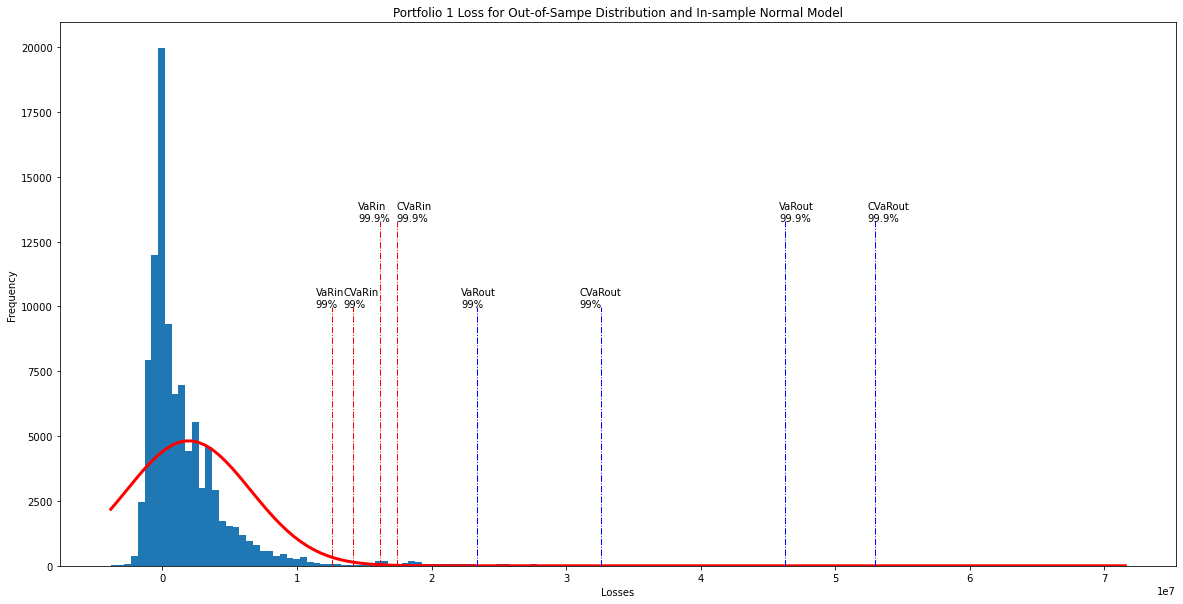

In [35]:
#Portfolio 1 (both 99% and 99.9% tile) Out-of Sample and Normal
plt.figure(figsize=(20,10))
loss_out_1=np.dot(Losses_out,x0[0])
frequencyCounts, binLocations, patches = plt.hist(loss_out_1, 150)
normf = (1 / (np.std(loss_out_1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_out_1)) / np.std(loss_out_1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)

#Out-of sample
#99%
plt.plot([VaRout[0][0], VaRout[0][0]], [0, max(frequencyCounts) / 2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0][0], CVaRout[0][0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[0][0], max(frequencyCounts) / 2, 'VaRout\n99%')
plt.text(0.95 * CVaRout[0][0], max(frequencyCounts) / 2, 'CVaRout\n99%')
#99.9%
plt.plot([VaRout[0][1], VaRout[0][1]], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0][1], CVaRout[0][1]], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.99 * VaRout[0][1], max(frequencyCounts) / 1.5, 'VaRout\n99.9%')
plt.text(0.99 * CVaRout[0][1], max(frequencyCounts) / 1.5, 'CVaRout\n99.9%')

# Normal approximation computed from out-of-sample scenarios (in-sample normal for out-of sample)
#99%
plt.plot([VaRinN[0][0], VaRinN[0][0]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0][0], CVaRinN[0][0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[0][0], max(frequencyCounts) / 2, 'VaRin\n99%')
plt.text(0.95 * CVaRinN[0][0], max(frequencyCounts) / 2, 'CVaRin\n99%')
#99.9%
plt.plot([VaRinN[0][1], VaRinN[0][1]], [0, max(frequencyCounts) / 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0][1], CVaRinN[0][1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[0][1], max(frequencyCounts) / 1.5, 'VaRin\n99.9%')
plt.text(1 * CVaRinN[0][1], max(frequencyCounts) / 1.5, 'CVaRin\n99.9%')


plt.title('Portfolio 1 Loss for Out-of-Sampe Distribution and In-sample Normal Model')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

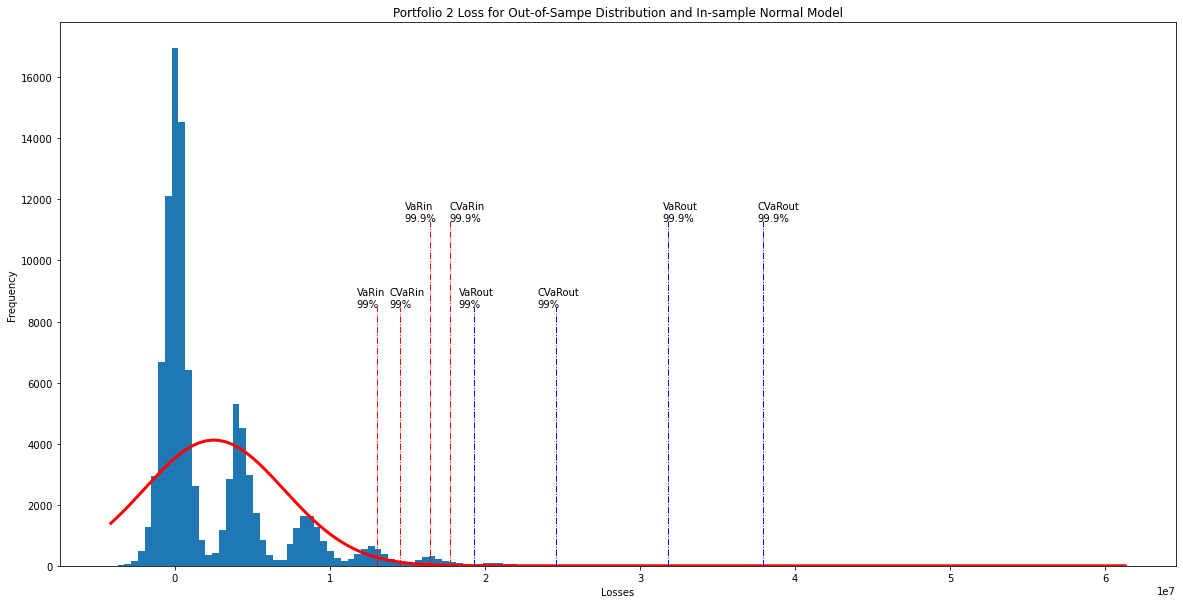

In [27]:
#Portfolio 2 (both 99% and 99.9% tile) Out-of Sample and Normal

plt.figure(figsize=(20,10))
loss_out_1=np.dot(Losses_out,x0[1])
frequencyCounts, binLocations, patches = plt.hist(loss_out_1, 150)
normf = (1 / (np.std(loss_out_1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_out_1)) / np.std(loss_out_1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)

#Out-of sample
#99%
plt.plot([VaRout[1][0], VaRout[1][0]], [0, max(frequencyCounts) / 2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1][0], CVaRout[1][0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[1][0], max(frequencyCounts) / 2, 'VaRout\n99%')
plt.text(0.95 * CVaRout[1][0], max(frequencyCounts) / 2, 'CVaRout\n99%')
#99.9%
plt.plot([VaRout[1][1], VaRout[1][1]], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1][1], CVaRout[1][1]], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.99 * VaRout[1][1], max(frequencyCounts) / 1.5, 'VaRout\n99.9%')
plt.text(0.99 * CVaRout[1][1], max(frequencyCounts) / 1.5, 'CVaRout\n99.9%')

# Normal approximation computed from out-of-sample scenarios (in-sample normal for out-of sample)
#99%
plt.plot([VaRinN[1][0], VaRinN[1][0]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1][0], CVaRinN[1][0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[1][0], max(frequencyCounts) / 2, 'VaRin\n99%')
plt.text(0.95 * CVaRinN[1][0], max(frequencyCounts) / 2, 'CVaRin\n99%')
#99.9%
plt.plot([VaRinN[1][1], VaRinN[1][1]], [0, max(frequencyCounts) / 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1][1], CVaRinN[1][1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[1][1], max(frequencyCounts) / 1.5, 'VaRin\n99.9%')
plt.text(1 * CVaRinN[1][1], max(frequencyCounts) / 1.5, 'CVaRin\n99.9%')


plt.title('Portfolio 2 Loss for Out-of-Sampe Distribution and In-sample Normal Model')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

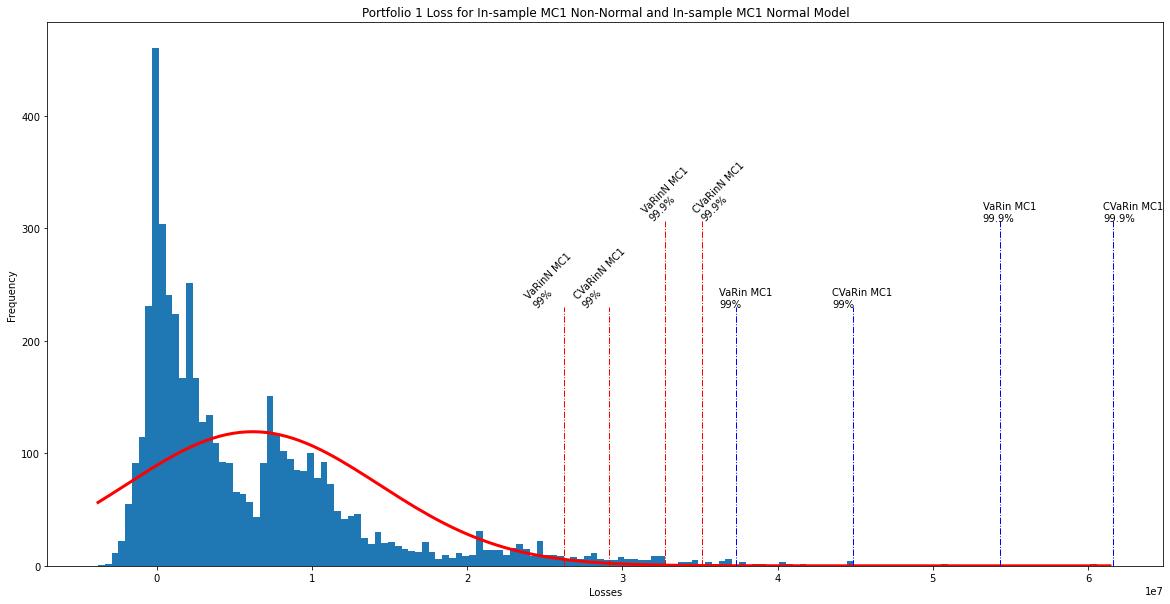

In [28]:
#Portfolio 1 (both 99% and 99.9% tile) In-Sample MC1 and Normal

plt.figure(figsize=(20,10))
loss_out_MC1=np.dot(Losses_inMC1,x0[0])
frequencyCounts, binLocations, patches = plt.hist(loss_out_MC1, 150)
normf = (1 / (np.std(loss_out_MC1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_out_MC1)) / np.std(loss_out_MC1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)


#In sample MC1
#99%
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts) / 2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.97 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 2, 'VaRin MC1\n99%')
plt.text(0.97 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 2, 'CVaRin MC1\n99%')
#99.9%
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.98 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 1.5, 'VaRin MC1\n99.9%')
plt.text(0.99 * np.mean(CVaRinMC1[0,1]), max(frequencyCounts) / 1.5, 'CVaRin MC1\n99.9%')

#In sample MC1 - Normal Model

plt.plot([np.mean(VaRinN1[0,0]), np.mean(VaRinN1[0,0])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[0,0]), np.mean(CVaRinN1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN1[0,0]), max(frequencyCounts) / 2, 'VaRinN MC1\n99%',rotation=45)
plt.text(0.92 * np.mean(CVaRinN1[0,0]), max(frequencyCounts) / 2, 'CVaRinN MC1\n99%',rotation=45)
#99.9%
plt.plot([np.mean(VaRinN1[0,1]), np.mean(VaRinN1[0,1])], [0, max(frequencyCounts) / 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[0,1]), np.mean(CVaRinN1[0,1])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[0,1]), max(frequencyCounts) / 1.5, 'VaRinN MC1\n99.9%',rotation=45)
plt.text(0.98 * np.mean(CVaRinN1[0,1]), max(frequencyCounts) / 1.5, 'CVaRinN MC1\n99.9%',rotation=45)


plt.title('Portfolio 1 Loss for In-sample MC1 Non-Normal and In-sample MC1 Normal Model')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

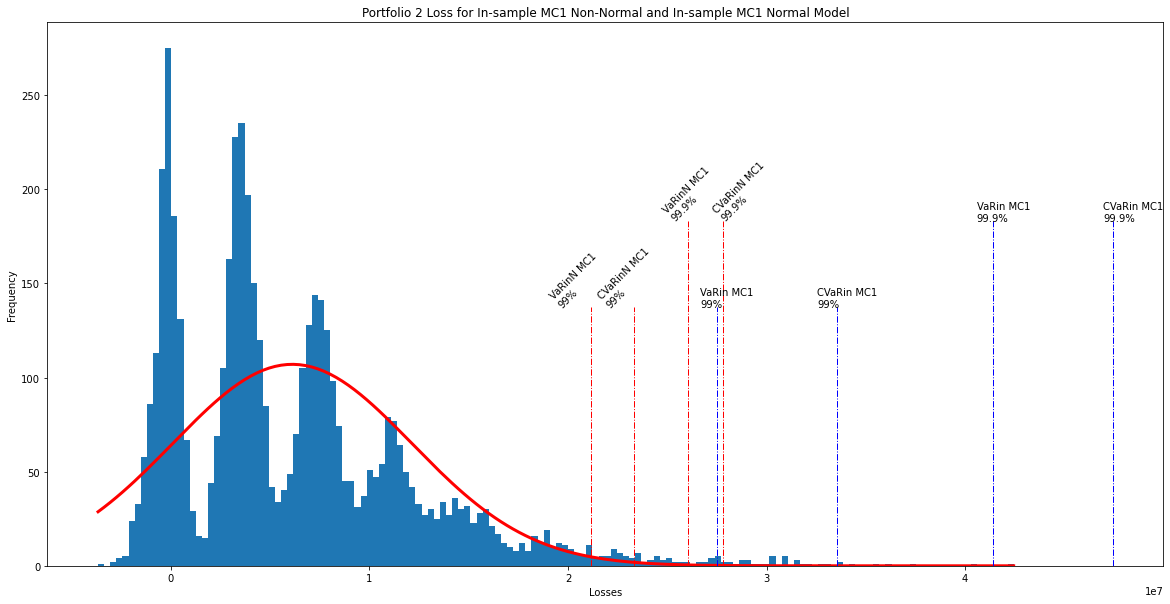

In [29]:
#Portfolio 2 (both 99% and 99.9% tile) In-Sample MC1 and Normal

plt.figure(figsize=(20,10))
loss_out_MC1=np.dot(Losses_inMC1,x0[1])
frequencyCounts, binLocations, patches = plt.hist(loss_out_MC1, 150)
normf = (1 / (np.std(loss_out_MC1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_out_MC1)) / np.std(loss_out_MC1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)


#In sample MC1
#99%
plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts) / 2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.97 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) / 2, 'VaRin MC1\n99%')
plt.text(0.97 * np.mean(CVaRinMC1[1,0]), max(frequencyCounts) / 2, 'CVaRin MC1\n99%')
#99.9%
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.98 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.5, 'VaRin MC1\n99.9%')
plt.text(0.99 * np.mean(CVaRinMC1[1,1]), max(frequencyCounts) / 1.5, 'CVaRin MC1\n99.9%')

#In sample MC1 - Normal Model

plt.plot([np.mean(VaRinN1[1,0]), np.mean(VaRinN1[1,0])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[1,0]), np.mean(CVaRinN1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN1[1,0]), max(frequencyCounts) / 2, 'VaRinN MC1\n99%',rotation=45)
plt.text(0.92 * np.mean(CVaRinN1[1,0]), max(frequencyCounts) / 2, 'CVaRinN MC1\n99%',rotation=45)
#99.9%
plt.plot([np.mean(VaRinN1[1,1]), np.mean(VaRinN1[1,1])], [0, max(frequencyCounts) / 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[1,1]), np.mean(CVaRinN1[1,1])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[1,1]), max(frequencyCounts) / 1.5, 'VaRinN MC1\n99.9%',rotation=45)
plt.text(0.98 * np.mean(CVaRinN1[1,1]), max(frequencyCounts) / 1.5, 'CVaRinN MC1\n99.9%',rotation=45)


plt.title('Portfolio 2 Loss for In-sample MC1 Non-Normal and In-sample MC1 Normal Model')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

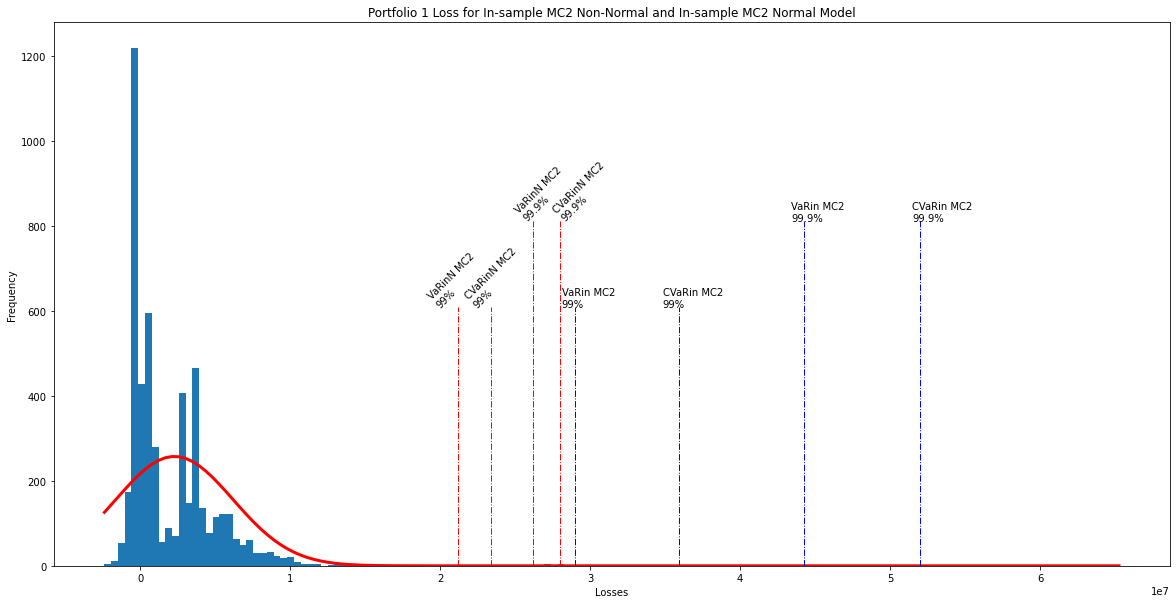

In [30]:
#Portfolio 1 (both 99% and 99.9% tile) In-Sample MC2 and Normal

plt.figure(figsize=(20,10))
loss_out_MC2=np.dot(Losses_inMC2,x0[0])
frequencyCounts, binLocations, patches = plt.hist(loss_out_MC2, 150)
normf = (1 / (np.std(loss_out_MC2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_out_MC2)) / np.std(loss_out_MC2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)

#In sample MC2
#99%
plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts) / 2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.97 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 2, 'VaRin MC2\n99%')
plt.text(0.97 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2, 'CVaRin MC2\n99%')
#99.9%
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.98 * np.mean(VaRinMC2[0,1]), max(frequencyCounts) / 1.5, 'VaRin MC2\n99.9%')
plt.text(0.99 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts) / 1.5, 'CVaRin MC2\n99.9%')

#In sample MC1 - Normal Model
plt.plot([np.mean(VaRinN2[0,0]), np.mean(VaRinN2[0,0])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[0,0]), np.mean(CVaRinN2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN2[0,0]), max(frequencyCounts) / 2, 'VaRinN MC2\n99%',rotation=45)
plt.text(0.92 * np.mean(CVaRinN2[0,0]), max(frequencyCounts) / 2, 'CVaRinN MC2\n99%',rotation=45)
#99.9%
plt.plot([np.mean(VaRinN2[0,1]), np.mean(VaRinN2[0,1])], [0, max(frequencyCounts) / 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[0,1]), np.mean(CVaRinN2[0,1])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[0,1]), max(frequencyCounts) / 1.5, 'VaRinN MC2\n99.9%',rotation=45)
plt.text(0.98 * np.mean(CVaRinN2[0,1]), max(frequencyCounts) / 1.5, 'CVaRinN MC2\n99.9%',rotation=45)


plt.title('Portfolio 1 Loss for In-sample MC2 Non-Normal and In-sample MC2 Normal Model')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()


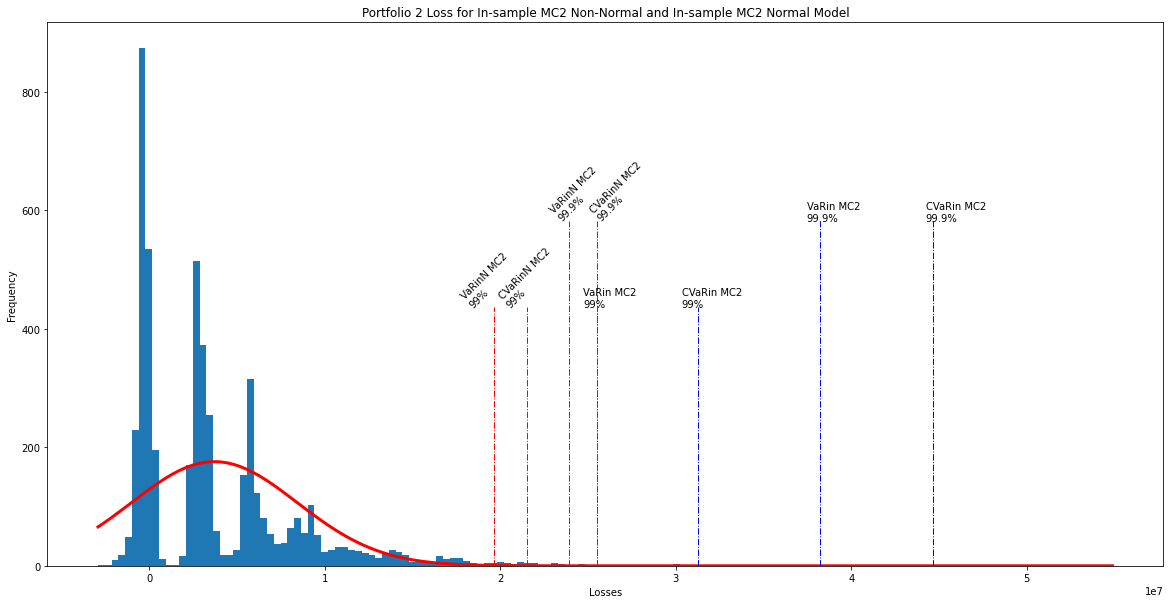

In [31]:
#Portfolio 2 (both 99% and 99.9% tile) In-Sample MC2 and Normal
plt.figure(figsize=(20,10))
loss_out_MC2=np.dot(Losses_inMC2,x0[1])
frequencyCounts, binLocations, patches = plt.hist(loss_out_MC2, 150)
normf = (1 / (np.std(loss_out_MC2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_out_MC2)) / np.std(loss_out_MC2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)

#In sample MC2
#99%
plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts) / 2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.97 * np.mean(VaRinMC2[1,0]), max(frequencyCounts) / 2, 'VaRin MC2\n99%')
plt.text(0.97 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts) / 2, 'CVaRin MC2\n99%')
#99.9%
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.98 * np.mean(VaRinMC2[1,1]), max(frequencyCounts) / 1.5, 'VaRin MC2\n99.9%')
plt.text(0.99 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts) / 1.5, 'CVaRin MC2\n99.9%')

#In sample MC1 - Normal Model
plt.plot([np.mean(VaRinN2[1,0]), np.mean(VaRinN2[1,0])], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[1,0]), np.mean(CVaRinN2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN2[1,0]), max(frequencyCounts) / 2, 'VaRinN MC2\n99%',rotation=45)
plt.text(0.92 * np.mean(CVaRinN2[1,0]), max(frequencyCounts) / 2, 'CVaRinN MC2\n99%',rotation=45)
#99.9%
plt.plot([np.mean(VaRinN2[1,1]), np.mean(VaRinN2[1,1])], [0, max(frequencyCounts) / 1.5], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[1,1]), np.mean(CVaRinN2[1,1])], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[1,1]), max(frequencyCounts) / 1.5, 'VaRinN MC2\n99.9%',rotation=45)
plt.text(0.98 * np.mean(CVaRinN2[1,1]), max(frequencyCounts) / 1.5, 'CVaRinN MC2\n99.9%',rotation=45)


plt.title('Portfolio 2 Loss for In-sample MC2 Non-Normal and In-sample MC2 Normal Model')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()


In [32]:
#Original Data Frame
df1 = pd.read_csv('instrum_data.csv', header=None)
df1.columns = [
    "Counterparty ID", "Credit Risk Driver",
    "Beta (Sensitivity to Credit Driver)", "Expected Recovery Rate", "Value",
    "Pr(default)", "Pr(CCC)", "Pr(B)", "Pr(BB)", "Pr(BBB)", "Pr(A)", "Pr(AA)",
    "Pr(AAA)", "L(default)", "L(CCC)", "L(B)", "L(BB)", "L(BBB)", "L(A)",
    "L(AA)", "L(AAA)", "Market Returns"
]
df1.style.format({
    "Beta (Sensitivity to Credit Driver)": "{:.4f}",
    "Expected Recovery Rate": "{:.2f}",
    "Value": "{:,.0f}",
    "Pr(default)": "{:.4f}",
    "Pr(CCC)": "{:.4f}",
    "Pr(B)": "{:.4f}",
    "Pr(BB)": "{:.4f}",
    "Pr(BBB)": "{:.4f}",
    "Pr(A)": "{:.4f}",
    "Pr(AA)": "{:.4f}",
    "Pr(AAA)": "{:.4f}",
    "L(default)": "{:,.0f}",
    "L(CCC)": "{:,.0f}",
    "L(B)": "{:,.0f}",
    "L(BB)": "{:,.0f}",
    "L(BBB)": "{:,.0f}",
    "L(A)": "{:,.0f}",
    "L(AA)": "{:,.0f}",
    "L(AAA)": "{:,.0f}",
    "Market Returns": "{:.4%}"
}).hide_index().set_table_styles([{
    'selector':
    '',
    'props': [('border', '5px solid black'), ('font-size', '15px')]
}, {
    'selector': 'td',
    'props': 'text-align: center;'
}])

Counterparty ID,Credit Risk Driver,Beta (Sensitivity to Credit Driver),Expected Recovery Rate,Value,Pr(default),Pr(CCC),Pr(B),Pr(BB),Pr(BBB),Pr(A),Pr(AA),Pr(AAA),L(default),L(CCC),L(B),L(BB),L(BBB),L(A),L(AA),L(AAA),Market Returns
1,1,0.5568,0.62,"10,255,741",0.0002,0.0001,0.0013,0.0050,0.0507,0.9183,0.0239,0.0005,"10,255,741","503,640","201,280","59,625","11,484",0,-500,"-1,500",7.0315%
2,2,0.5568,0.60,"9,997,200",0.0002,0.0001,0.0013,0.0050,0.0507,0.9183,0.0239,0.0005,"9,997,200","939,798","398,956","124,925","23,465",0,"-3,250","-5,000",7.0435%
3,3,0.5568,0.70,"1,990,657",0.0127,0.0055,0.0705,0.8512,0.0545,0.0050,0.0005,0.0001,"1,990,657","127,827","49,364",0,"-22,345","-28,192","-29,480","-29,884",10.4110%
4,3,0.5568,0.58,"37,524,383",0.0127,0.0055,0.0705,0.8512,0.0545,0.0050,0.0005,0.0001,"37,524,383","2,820,870","1,006,907",0,"-405,563","-496,704","-517,622","-523,328",10.4342%
5,4,0.5568,0.54,"4,997,650",0.0018,0.0016,0.0080,0.0488,0.8849,0.0520,0.0024,0.0005,"4,997,650","459,148","188,151","50,840",0,"-11,759","-13,387","-14,264",8.2614%
6,5,0.5568,0.66,"5,129,617",0.0018,0.0016,0.0080,0.0488,0.8849,0.0520,0.0024,0.0005,"5,129,617","246,527","95,071","24,115",0,"-5,752","-6,002","-6,503",8.2193%
7,6,0.5568,0.58,"7,493,628",0.0018,0.0016,0.0080,0.0488,0.8849,0.0520,0.0024,0.0005,"7,493,628","739,506","285,185","72,337",0,"-17,255","-18,006","-19,508",8.2607%
8,7,0.5172,0.56,"5,127,523",0.0002,0.0001,0.0013,0.0050,0.0507,0.9183,0.0239,0.0005,"5,127,523","168,243","93,177","37,142","8,482",0,"-1,813","-2,438",7.0338%
9,7,0.5172,0.62,"4,999,239",0.0002,0.0000,0.0001,0.0007,0.0026,0.0763,0.9084,0.0117,"4,999,239","254,341","175,537","78,520","22,370","3,647",0,"-1,292",6.0279%
10,8,0.5172,0.56,"5,269,755",0.0664,0.0304,0.8320,0.0652,0.0043,0.0013,0.0003,0.0001,"5,269,755","125,378",0,"-69,595","-97,627","-103,926","-105,372","-105,766",16.6149%
